### 1. Data prepare

In [1]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def query_prom(query, startTime, endTime):
    PROMETHEUS = 'http://20.71.55.156:9090/'
    response = requests.get(PROMETHEUS + '/api/v1/query_range',
      params={'query': query,
              'start': startTime,
              'end': endTime,
              'step': '15s'})
    results = response.json()['data']['result']
    return results

In [3]:
startTime = 1619692800
endTime = 1619696520

startTime = 1621335960
endTime = 1621343220

In [4]:
# Caliper data for label
txn_failure = 'caliper_txn_failure'
txn_failure = query_prom(txn_failure, startTime, endTime)[0]
time = list(map(int, np.array(txn_failure['values'])[:,0]))
value_t = list(map(float, np.array(txn_failure['values'])[:,1]))
# transfer time from timestamp to datetime
time_ax = []
for each in time:
    time_ax.append(datetime.datetime.fromtimestamp(each))
label = [0]
for i in range(1,len(value_t)):
    if value_t[i]-value_t[i-1] != 0:
        label.append(1)
    else:
        label.append(0)
label_data = pd.DataFrame({'time': time_ax,'label': label})

In [5]:
# CPU load data for anomaly detection
disk_iops_query = 'irate(node_disk_writes_completed_total{device="sdb",instance="nodeexporter1",job="nodeexporter"}[5m])'
disk_iops = query_prom(disk_iops_query, startTime, endTime)[0]
#time = list(map(int, np.array(disk_iops['values'])[:,0]))
value = list(map(float, np.array(disk_iops['values'])[:,1]))
# time_ax = []
# for each in time:
#     time_ax.append(datetime.datetime.fromtimestamp(each))
label_data['disk_iops'] = value
print(label_data)

                   time  label  disk_iops
0   2021-05-18 13:06:00      0        0.2
1   2021-05-18 13:06:15      0        0.2
2   2021-05-18 13:06:30      0        0.2
3   2021-05-18 13:06:45      1        0.2
4   2021-05-18 13:07:00      0        0.2
..                  ...    ...        ...
480 2021-05-18 15:06:00      0        0.2
481 2021-05-18 15:06:15      0        0.0
482 2021-05-18 15:06:30      0        0.2
483 2021-05-18 15:06:45      0        0.0
484 2021-05-18 15:07:00      0        0.2

[485 rows x 3 columns]


In [11]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))
print(label_data.drop(['time'], axis=1))
clf = svm.SVC()
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(label_data.drop(['time'], axis=1).to_numpy(), caliper_txn_failure)

for i in range(len(label_data)):
    print(clf.predict([list(label_data.drop(['time'], axis=1).iloc[i])]))

     label  disk_iops
0        0        0.2
1        0        0.2
2        0        0.2
3        1        0.2
4        0        0.2
..     ...        ...
480      0        0.2
481      0        0.0
482      0        0.2
483      0        0.0
484      0        0.2

[485 rows x 2 columns]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0

### Plot time series data

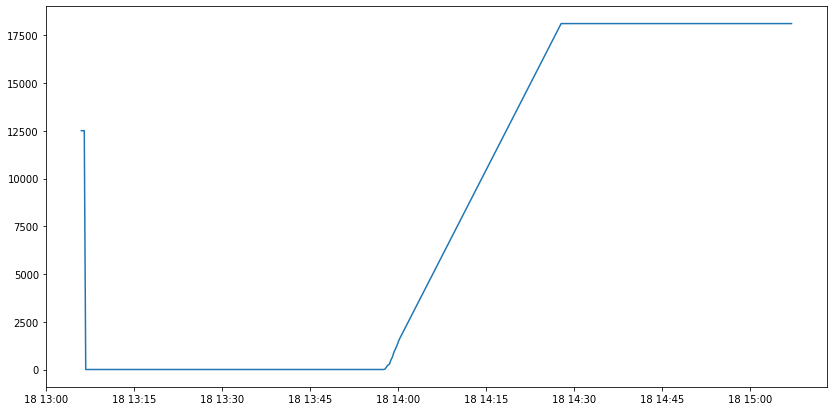

In [6]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(time_ax,value_t)
plt.show()

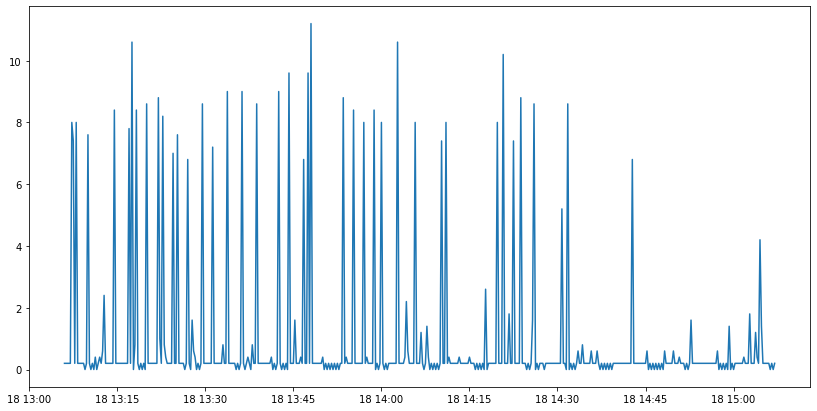

In [7]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(time_ax,value)
plt.show()

NameError: name 'df' is not defined

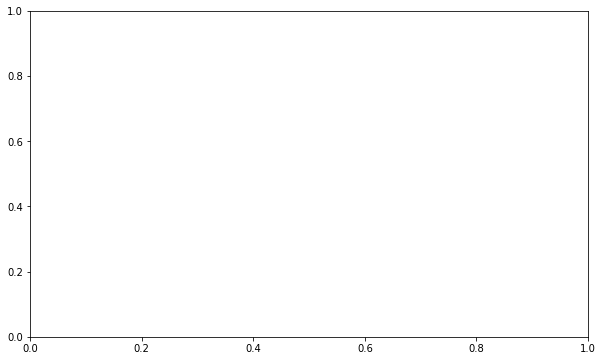

In [8]:
#plot predict vs real data
fig, ax = plt.subplots(figsize=(10,6))
#a = df.loc[df['anomaly_arima'] == 1, ['time', 'disk_iops']] #anomaly
b = df.loc[df['label'] == 1, ['time', 'disk_iops']] #anomaly
ax.plot(df['time'], df['disk_iops'], color='blue')
#ax.scatter(a['time'],a['disk_iops'], color='red', label='Anomaly')
ax.scatter(b['time'],b['disk_iops'], color='green', label='Normal')
plt.legend()
plt.show()

### Time windows

In [253]:
df = label_data
r_df = df['disk_iops'].rolling(window = 5)
print(r_df.mean())

0             NaN
1             NaN
2             NaN
3             NaN
4        2.640000
          ...    
244    103.600000
245    104.706856
246    104.986856
247    105.826856
248    104.666856
Name: disk_iops, Length: 249, dtype: float64


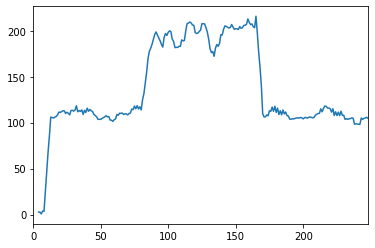

In [254]:
r_df.mean().plot()
plt.show()

### ARIMA

1619822690.58042
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2142.941, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2190.317, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2144.929, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2141.708, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2188.420, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2143.097, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2140.337, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2142.001, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2141.896, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2144.560, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2144.410, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2143.230, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2138.720, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2141.480, Time=0.03 sec
 ARIMA(1,1,1)(0,

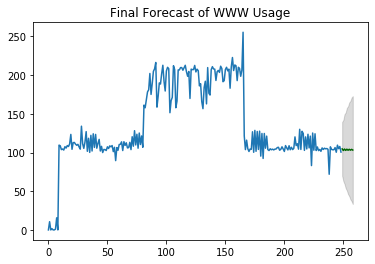

In [257]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
df = label_data
print(time.time())
model = pm.auto_arima(df.disk_iops, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(time.time())
print(model.summary())

# Forecast
n_periods = 10
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.disk_iops), len(df.disk_iops)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.disk_iops)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

1619822698.92034
1619822698.969713


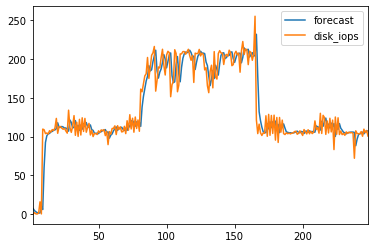

In [258]:
# Actual vs Fitted
from statsmodels.tsa.arima_model import ARIMA
print(time.time())
model = ARIMA(df.disk_iops, order=(1,1,1))
model_fit = model.fit(disp=0)
print(time.time())
model_fit.plot_predict(dynamic=False)
plt.show()

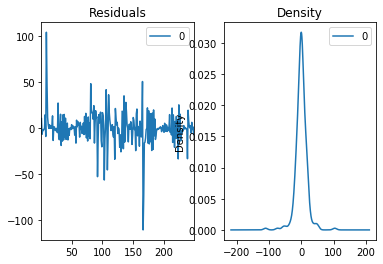

In [259]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [260]:
df[df['label']==1]
true_label = df['label'].tolist()
#print(true_label)

In [261]:
# Plot box to detect anomaly data
res_data = residuals[0]
bound = res_data.quantile([0.05,0.5,0.95])
anomaly_idx1 = res_data.ix[res_data > bound.iloc[2]]
anomaly_idx2 = res_data.ix[res_data < bound.iloc[0]]
anomaly_idx = anomaly_idx1.index.tolist()+anomaly_idx2.index.tolist()
pred_label = [0] * len(true_label)
for i in anomaly_idx:
    pred_label[i] = 1
#print(pred_label)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


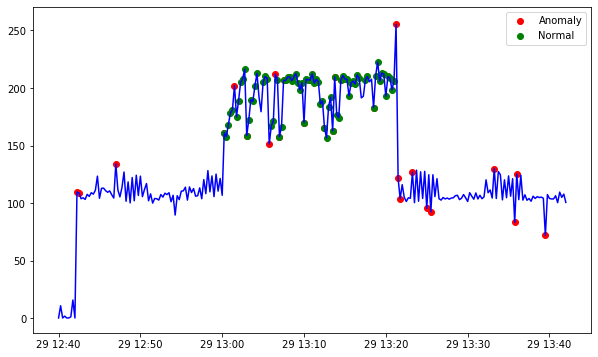

In [262]:
#plot predict vs real data
df['anomaly_arima'] = pd.Series(pred_label)
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_arima'] == 1, ['time', 'disk_iops']] #anomaly
b = df.loc[df['label'] == 1, ['time', 'disk_iops']] #anomaly
ax.plot(df['time'], df['disk_iops'], color='blue')
ax.scatter(a['time'],a['disk_iops'], color='red', label='Anomaly')
ax.scatter(b['time'],b['disk_iops'], color='green', label='Normal')
plt.legend()
plt.show()

In [263]:
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
# accuracy
accuracy = accuracy_score(true_label,pred_label)
print('Accuracy: ', accuracy)
# precision
precision = precision_score(true_label, pred_label, average='macro')
print('Precision: ', precision)
# recall
recall = metrics.recall_score(true_label, pred_label, average='macro')
print('Recall: ', recall)
f1_score = metrics.f1_score(true_label, pred_label, average='macro') 
print('F1 score: ', f1_score)

Accuracy:  0.6746987951807228
Precision:  0.546567781993791
Recall:  0.5206896551724138
F1 score:  0.4969947876399732


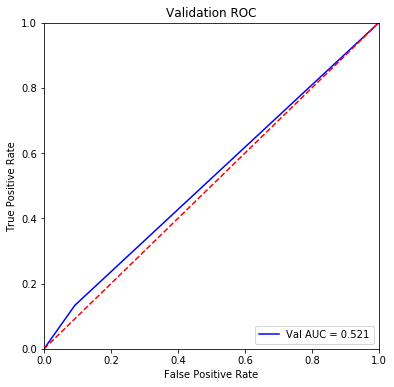

In [264]:
# AUC curve
fpr, tpr, threshold = metrics.roc_curve(true_label, pred_label)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### STL

1619822720.37631
1619822720.379406


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """


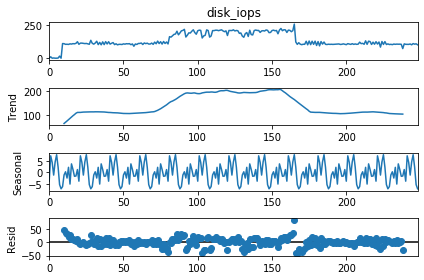

In [265]:
import statsmodels.api as sm
df = label_data
print(time.time())
df.disk_iops.interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(df.disk_iops, freq=20)
print(time.time())
res.plot()
plt.show()

In [266]:
# Plot-box to detect anomaly data
res_data = res.resid.dropna() 
bound = res_data.quantile([0.05,0.5,0.95])
anomaly_idx1 = res_data.ix[res_data > bound.iloc[2]]
anomaly_idx2 = res_data.ix[res_data < bound.iloc[0]]
anomaly_idx = anomaly_idx1.index.tolist()+anomaly_idx2.index.tolist()
pred_label = [0] * len(true_label)
for i in anomaly_idx:
    pred_label[i] = 1
#print(pred_label)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


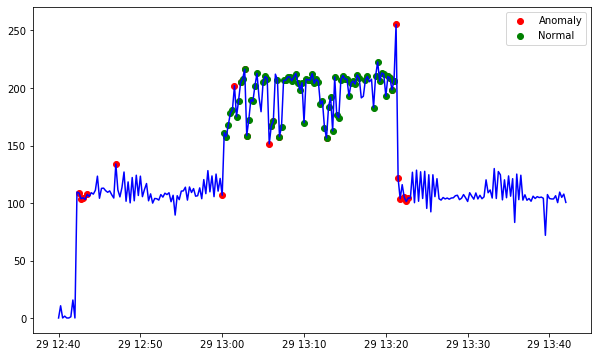

In [267]:
#plot predict vs real data
df['anomaly_stl'] = pd.Series(pred_label)
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_stl'] == 1, ['time', 'disk_iops']] #anomaly
b = df.loc[df['label'] == 1, ['time', 'disk_iops']] #anomaly
ax.plot(df['time'], df['disk_iops'], color='blue')
ax.scatter(a['time'],a['disk_iops'], color='red', label='Anomaly')
ax.scatter(b['time'],b['disk_iops'], color='green', label='Normal')
plt.legend()
plt.show()

In [269]:
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
# accuracy
accuracy = accuracy_score(true_label,pred_label)
print('Accuracy: ', accuracy)
# precision
precision = precision_score(true_label, pred_label, average='macro')
print('Precision: ', precision)
# recall
recall = metrics.recall_score(true_label, pred_label, average='macro')
print('Recall: ', recall)
f1_score = metrics.f1_score(true_label, pred_label, average='macro') 
print('F1 score: ', f1_score)

Accuracy:  0.6827309236947792
Precision:  0.5638888888888889
Recall:  0.5264367816091954
F1 score:  0.5020126072757652


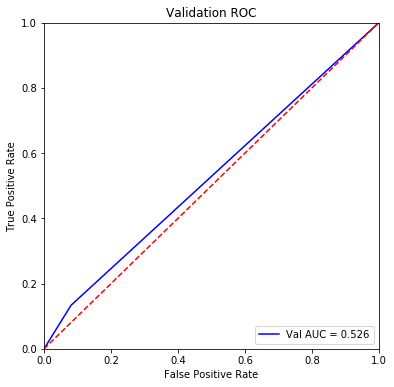

In [270]:
# AUC curve
fpr, tpr, threshold = metrics.roc_curve(true_label, pred_label)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Feature selection

In [405]:
df = label_data
time1 = df['time'].astype(str).str.split(' ',expand=True)
df = pd.merge(df, time1, how='left', left_index=True, right_index=True)
time2 = df.iloc[:,-2].str.split('-', expand=True)
time3 = df.iloc[:,-1].str.split(':', expand=True)
df = pd.merge(df, time2, how='left', left_index=True, right_index=True)
df = pd.merge(df, time3, how='left', left_index=True, right_index=True)
print(df)

                   time  label   disk_iops         0_x       1_x   0_y 1_y  \
0   2021-04-29 12:40:00      0    0.200000  2021-04-29  12:40:00  2021  04   
1   2021-04-29 12:40:15      0   10.800000  2021-04-29  12:40:15  2021  04   
2   2021-04-29 12:40:30      0    0.200000  2021-04-29  12:40:30  2021  04   
3   2021-04-29 12:40:45      0    1.800000  2021-04-29  12:40:45  2021  04   
4   2021-04-29 12:41:00      0    0.200000  2021-04-29  12:41:00  2021  04   
..                  ...    ...         ...         ...       ...   ...  ..   
244 2021-04-29 13:41:00      0  100.400000  2021-04-29  13:41:00  2021  04   
245 2021-04-29 13:41:15      0  109.534279  2021-04-29  13:41:15  2021  04   
246 2021-04-29 13:41:30      0  105.000000  2021-04-29  13:41:30  2021  04   
247 2021-04-29 13:41:45      0  107.800000  2021-04-29  13:41:45  2021  04   
248 2021-04-29 13:42:00      0  100.600000  2021-04-29  13:42:00  2021  04   

    2_x   0   1 2_y  
0    29  12  40  00  
1    29  12  40  15

In [406]:
import sklearn.preprocessing as preprocessing
# normarize value
min_max_scaler = preprocessing.MinMaxScaler()
value_minmax = min_max_scaler.fit_transform(df[['disk_iops']])

In [407]:
def encode_time(df):  
    label=preprocessing.LabelEncoder()
    labels=label.fit_transform(df)
    labels=labels.reshape(len(labels),1)
    onehot=preprocessing.OneHotEncoder()
    onehot_label=onehot.fit_transform(labels)
    return onehot_label
label_min = encode_time(df.iloc[:,-2])
label_hour = encode_time(df.iloc[:,-3])
label_day = encode_time(df.iloc[:,-4])
label_month = encode_time(df.iloc[:,-5])
label_year = encode_time(df.iloc[:,-6])

In [408]:
from scipy.sparse import hstack,vstack
features = hstack((value_minmax, label_min, label_hour, label_day, label_month, label_year)).toarray()
#print(features)

### KNN

In [409]:
from sklearn.model_selection import train_test_split
df_features = pd.DataFrame(features)
X = df_features
Y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22)

In [283]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
print(time.time())
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, Y_train)
print(time.time())
score = model.score(X_test, Y_test)

1619822833.245238
1619822833.248733


In [277]:
y_test = model.predict(X_test)
print(y_test)
print(Y_test.tolist())

[0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 0 0 1 0 1 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


In [280]:
Y_res = Y_test.to_frame()
Y_res['pred_label'] = y_test

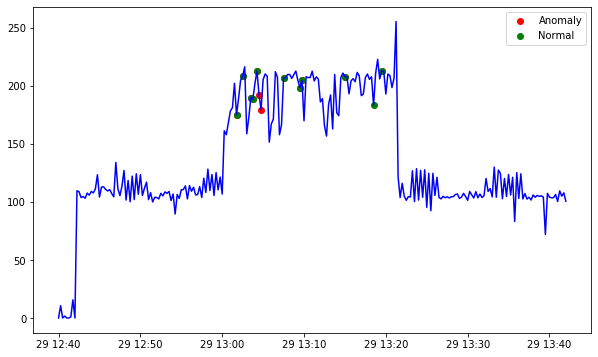

In [281]:
#plot predict vs real data
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[Y_res.loc[Y_res['pred_label']==1].index.tolist(), ['time', 'disk_iops']] #pred anomaly
b = df.loc[Y_res.loc[Y_res['label']==1].index.tolist(), ['time', 'disk_iops']] #anomaly
ax.plot(df['time'], df['disk_iops'], color='blue')
ax.scatter(a['time'],a['disk_iops'], color='red', label='Anomaly')
ax.scatter(b['time'],b['disk_iops'], color='green', label='Normal')
plt.legend()
plt.show()

Accuracy:  0.94
Precision:  0.9035087719298246
Recall:  0.9289044289044288
F1 score:  0.9153020892151327


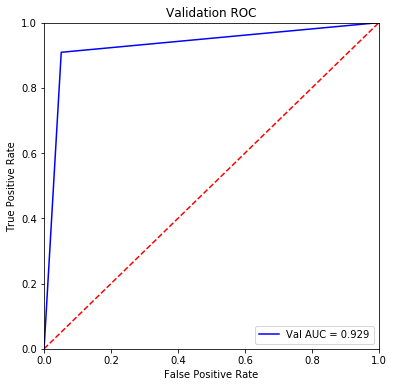

In [282]:
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
# accuracy
accuracy = accuracy_score(Y_test,y_test)
print('Accuracy: ', accuracy)
# precision
precision = precision_score(Y_test, y_test, average='macro')
print('Precision: ', precision)
# recall
recall = metrics.recall_score(Y_test, y_test, average='macro')
print('Recall: ', recall)
f1_score = metrics.f1_score(Y_test, y_test, average='macro') 
print('F1 score: ', f1_score)

# AUC curve
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_test)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### K-means 1

In [285]:
#k means for cpu loads
from sklearn.cluster import KMeans
data = pd.DataFrame(df.disk_iops)
print(time.time())
clf = KMeans(n_clusters=2)
clf.fit(data)
print(time.time())
print(clf.labels_)
#print(label_data.label.tolist())
label_data['pred_label_1'] = clf.labels_
print(label_data)

1619822856.745585
1619822856.76756
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
                   time  label   disk_iops  anomaly_arima  anomaly_stl  \
0   2021-04-29 12:40:00      0    0.200000              0            0   
1   2021-04-29 12:40:15      0   10.800000              0            0   
2   2021-04-29 12:40:30      0    0.200000              0            0   
3   2021-04-29 12:40:45      0    1.800000              0            0   
4   2021-04-29 12:41:00      0    0.200000              0            0   
..             

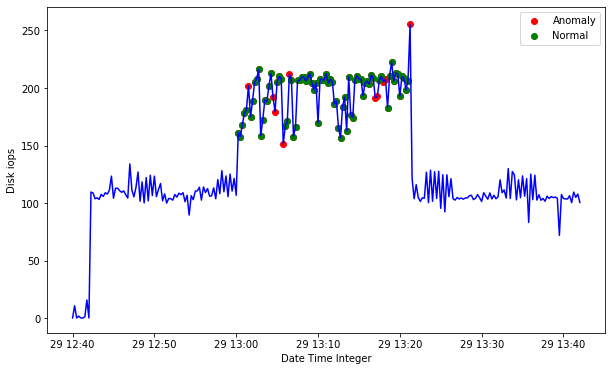

In [286]:
fig, ax = plt.subplots(figsize=(10,6))
df = label_data
a = df.loc[df['pred_label_1'] == 1, ['time', 'disk_iops']] #anomaly
b = df.loc[df['label'] == 1, ['time', 'disk_iops']] #anomaly
ax.plot(df['time'], df['disk_iops'], color='blue')
ax.scatter(a['time'],a['disk_iops'], color='red', label='Anomaly')
ax.scatter(b['time'],b['disk_iops'], color='green', label='Normal')
plt.xlabel('Date Time Integer')
plt.ylabel('Disk iops')
plt.legend()
plt.show()

Accuracy:  0.9598393574297188
Precision:  0.9411764705882353
Recall:  0.9712643678160919
F1 score:  0.953957100591716


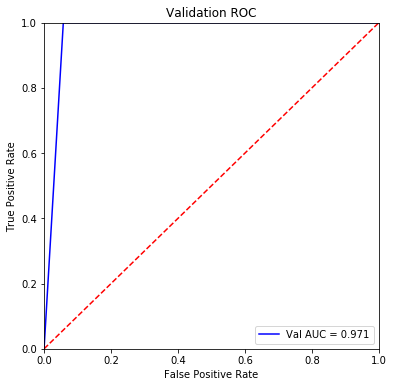

In [287]:
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
# accuracy
true_label = df['label']
pred_label = df['pred_label_1']
accuracy = accuracy_score(true_label,pred_label)
print('Accuracy: ', accuracy)
# precision
precision = precision_score(true_label, pred_label, average='macro')
print('Precision: ', precision)
# recall
recall = metrics.recall_score(true_label, pred_label, average='macro')
print('Recall: ', recall)
f1_score = metrics.f1_score(true_label, pred_label, average='macro') 
print('F1 score: ', f1_score)

# AUC curve
fpr, tpr, threshold = metrics.roc_curve(true_label, pred_label)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### K-means

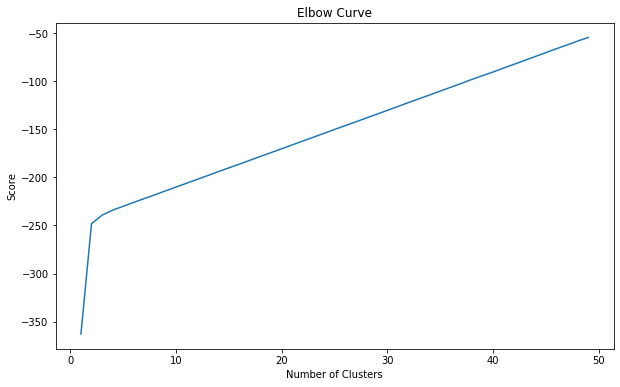

In [299]:
from sklearn.cluster import KMeans
df = label_data
data = df_features
n_cluster = range(1, 50)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

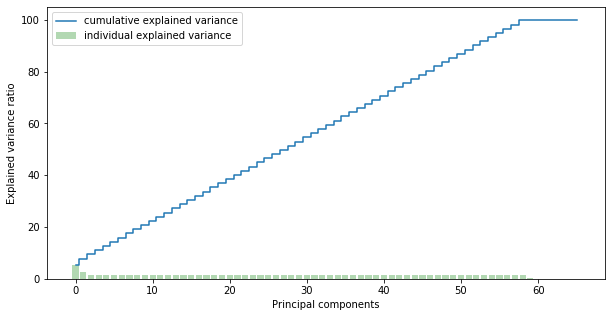

In [300]:
# Decide PCA components
from sklearn.preprocessing import StandardScaler
X = data
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

In [301]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
newData=pca.fit_transform(data)
df = label_data.join(pd.DataFrame(newData, columns=['principal_feature1','principal_feature2']))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


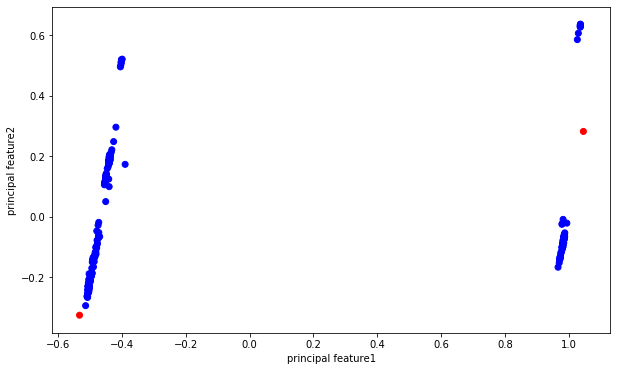

In [302]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[32])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show()

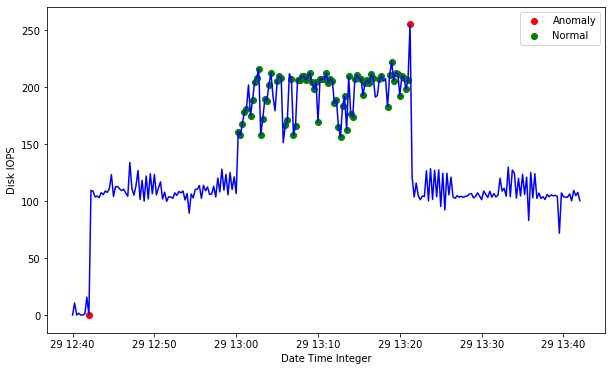

In [303]:
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly1'] == 1, ['time', 'disk_iops']] #anomaly
b = df.loc[df['label'] == 1, ['time', 'disk_iops']] #anomaly
ax.plot(df['time'], df['disk_iops'], color='blue')
ax.scatter(a['time'],a['disk_iops'], color='red', label='Anomaly')
ax.scatter(b['time'],b['disk_iops'], color='green', label='Normal')
plt.xlabel('Date Time Integer')
plt.ylabel('Disk IOPS')
plt.legend()
plt.show()

Accuracy:  0.6907630522088354
Precision:  0.3481781376518219
Recall:  0.4942528735632184
F1 score:  0.4085510688836104


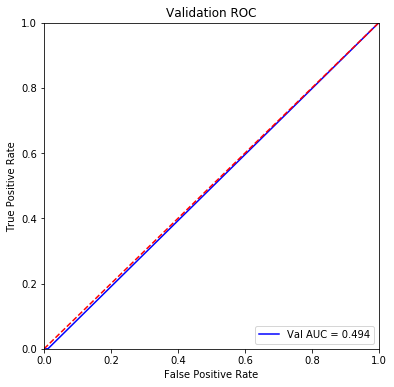

In [304]:
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
# accuracy
true_label = df['label']
pred_label = df['anomaly1']
accuracy = accuracy_score(true_label,pred_label)
print('Accuracy: ', accuracy)
# precision
precision = precision_score(true_label, pred_label, average='macro')
print('Precision: ', precision)
# recall
recall = metrics.recall_score(true_label, pred_label, average='macro')
print('Recall: ', recall)
f1_score = metrics.f1_score(true_label, pred_label, average='macro') 
print('F1 score: ', f1_score)

# AUC curve
fpr, tpr, threshold = metrics.roc_curve(true_label, pred_label)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Isolation forest

1619860537.5274932
1619860537.540385
                   time  label   disk_iops  anomaly_isoltree
0   2021-04-29 12:40:00      0    0.200000                -1
1   2021-04-29 12:40:15      0   10.800000                 1
2   2021-04-29 12:40:30      0    0.200000                -1
3   2021-04-29 12:40:45      0    1.800000                 1
4   2021-04-29 12:41:00      0    0.200000                -1
..                  ...    ...         ...               ...
244 2021-04-29 13:41:00      0  100.400000                 1
245 2021-04-29 13:41:15      0  109.534279                 1
246 2021-04-29 13:41:30      0  105.000000                 1
247 2021-04-29 13:41:45      0  107.800000                 1
248 2021-04-29 13:42:00      0  100.600000                 1

[249 rows x 4 columns]


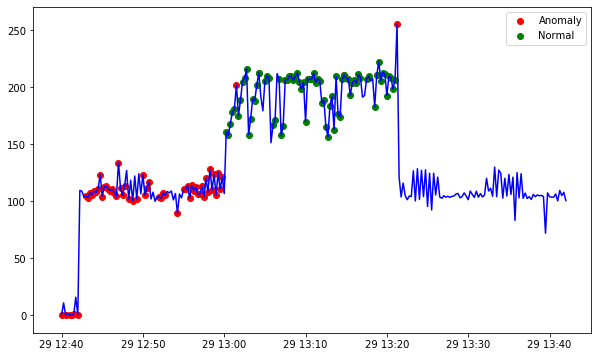

In [368]:
import time
from sklearn.svm import OneClassSVM
df = label_data
data = df_features
#scaler = StandardScaler()
#np_scaled = scaler.fit_transform(data)
#data = pd.DataFrame(np_scaled)
# train oneclassSVM 
print(time.time())
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
print(time.time())
df['anomaly_isoltree'] = pd.Series(model.predict(data))
print(df)
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_isoltree'] == -1, ['time', 'disk_iops']] #anomaly
b = df.loc[df['label'] == 1, ['time', 'disk_iops']] #anomaly
ax.plot(df['time'], df['disk_iops'], color='blue')
ax.scatter(a['time'],a['disk_iops'], color='red', label='Anomaly')
ax.scatter(b['time'],b['disk_iops'], color='green', label='Normal')
plt.legend()
plt.show()

Accuracy:  0.6907630522088354
Precision:  0.3481781376518219
Recall:  0.4942528735632184
F1 score:  0.4085510688836104


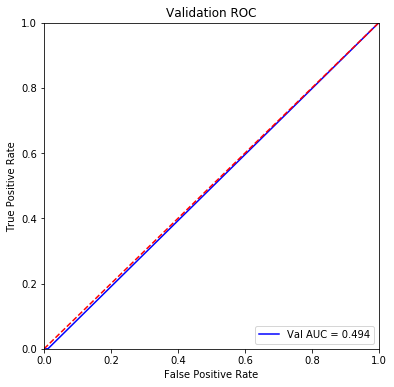

In [306]:
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
# accuracy
true_label = df['label']
df['anomaly_isoltree'] = df['anomaly_isoltree'].replace(1,0)
df['anomaly_isoltree'] = df['anomaly_isoltree'].replace(-1,1)
pre_label = df['anomaly_isoltree']
accuracy = accuracy_score(true_label,pred_label)
print('Accuracy: ', accuracy)
# precision
precision = precision_score(true_label, pred_label, average='macro')
print('Precision: ', precision)
# recall
recall = metrics.recall_score(true_label, pred_label, average='macro')
print('Recall: ', recall)
f1_score = metrics.f1_score(true_label, pred_label, average='macro') 
print('F1 score: ', f1_score)

# AUC curve
fpr, tpr, threshold = metrics.roc_curve(true_label, pred_label)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Auto Encoder

In [432]:
import tensorflow as tf
import seaborn as sns
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [433]:
df = label_data
df_features = pd.DataFrame(features)
df_f = df.join(df_features)
mask = df_f['label'] == 0
print(df_f)
df_f = df_f.drop(['time','disk_iops'], axis=1)
X_train, X_test = train_test_split(df_f[mask], test_size=0.2, random_state=920)
X_train = X_train.drop(['label'], axis=1).values
X_test = X_test.drop(['label'], axis=1).values

# test Sata
X_fraud = df_f[~mask].drop(['label'], axis=1).values

                   time  label   disk_iops         0    1    2    3    4    5  \
0   2021-04-29 12:40:00      0    0.200000  0.000000  0.0  0.0  0.0  0.0  0.0   
1   2021-04-29 12:40:15      0   10.800000  0.041569  0.0  0.0  0.0  0.0  0.0   
2   2021-04-29 12:40:30      0    0.200000  0.000000  0.0  0.0  0.0  0.0  0.0   
3   2021-04-29 12:40:45      0    1.800000  0.006275  0.0  0.0  0.0  0.0  0.0   
4   2021-04-29 12:41:00      0    0.200000  0.000000  0.0  0.0  0.0  0.0  0.0   
..                  ...    ...         ...       ...  ...  ...  ...  ...  ...   
244 2021-04-29 13:41:00      0  100.400000  0.392941  0.0  0.0  0.0  0.0  0.0   
245 2021-04-29 13:41:15      0  109.534279  0.428762  0.0  0.0  0.0  0.0  0.0   
246 2021-04-29 13:41:30      0  105.000000  0.410980  0.0  0.0  0.0  0.0  0.0   
247 2021-04-29 13:41:45      0  107.800000  0.421961  0.0  0.0  0.0  0.0  0.0   
248 2021-04-29 13:42:00      0  100.600000  0.393725  0.0  0.0  0.0  0.0  0.0   

       6  ...   56   57   5

Epoch 1/50
5/5 [==============================] - 0s 41ms/step - loss: 0.0830 - mae: 0.1331 - val_loss: 0.0803 - val_mae: 0.1287
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0791 - mae: 0.1195 - val_loss: 0.0772 - val_mae: 0.1177
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0768 - mae: 0.1108 - val_loss: 0.0750 - val_mae: 0.1100
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0750 - mae: 0.1031 - val_loss: 0.0731 - val_mae: 0.1049
Epoch 5/50
5/5 [==============================] - 0s 48ms/step - loss: 0.0731 - mae: 0.0993 - val_loss: 0.0712 - val_mae: 0.1019
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0715 - mae: 0.0964 - val_loss: 0.0692 - val_mae: 0.1002
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0694 - mae: 0.0957 - val_loss: 0.0670 - val_mae: 0.0994
Epoch 8/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0672 - mae: 0.0948 - val

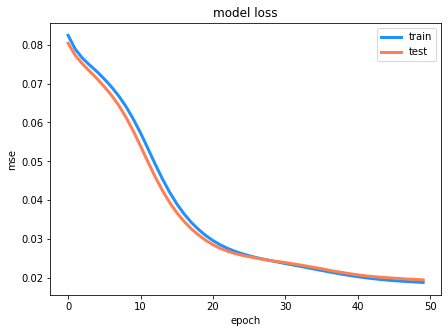

In [434]:
# Setup Autoencoder parameters
# Hidden layer: 16，8，8，16
# epoch:50，batch size:32
input_dim = X_train.shape[1]
encoding_dim = 16
num_epoch = 50
batch_size = 32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])

# Save model as cpu_model.h5, and train model
checkpointer = ModelCheckpoint(filepath="cpu_model.h5",
                               verbose=0,
                               save_best_only=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer]).history

# Plot loss curve
plt.figure(figsize=(7, 5))
plt.subplot(111)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# plt.subplot(122)
# plt.plot(history['mean_absolute_error'], c='dodgerblue', lw=3)
# plt.plot(history['val_mean_absolute_error'], c='coral', lw=3)
# plt.title('model mae')
# plt.ylabel('mae'); plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')

In [435]:
autoencoder = load_model('cpu_model.h5')
# test
pred_test = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)
# Calculate MSE and MAE
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)

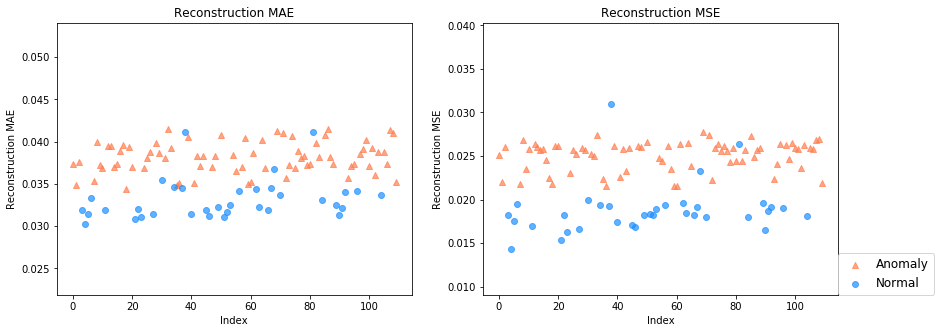

In [436]:
markers = ['o', '^']
#markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Normal', 'Anomaly']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE')
plt.xlabel('Index')

plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12); plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE')
plt.xlabel('Index')
plt.show()

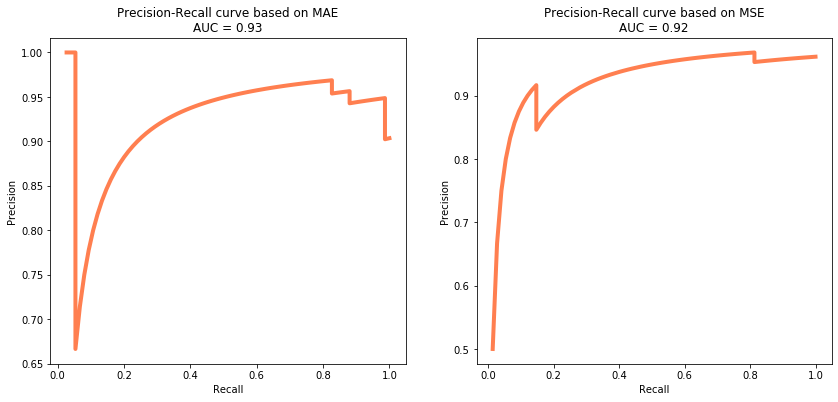

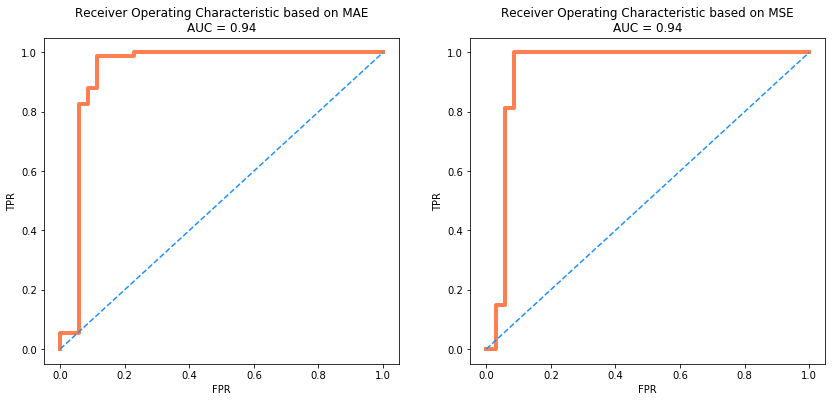

In [437]:
# Plot Precision-Recall
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    #accuracy = accuracy_score(mse_df['Class'], mse_df[metric])
    #print('Accuracy: ', accuracy)
    #f1_score = metrics.f1_score(mse_df['Class'], mse_df[metric], average='macro') 
    #print('F1 score: ', f1_score)
    precision, recall, _ = precision_recall_curve(mse_df['Class'], mse_df[metric])
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall curve based on %s\nAUC = %0.2f'%(metric, pr_auc))
    plt.plot(recall[:-2], precision[:-2], c='coral', lw=4)
    plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()

# Plot ROC
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    fpr, tpr, _ = roc_curve(mse_df['Class'], mse_df[metric])
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic based on %s\nAUC = %0.2f'%(metric, roc_auc))
    plt.plot(fpr, tpr, c='coral', lw=4)
    plt.plot([0,1],[0,1], c='dodgerblue', ls='--')
    plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

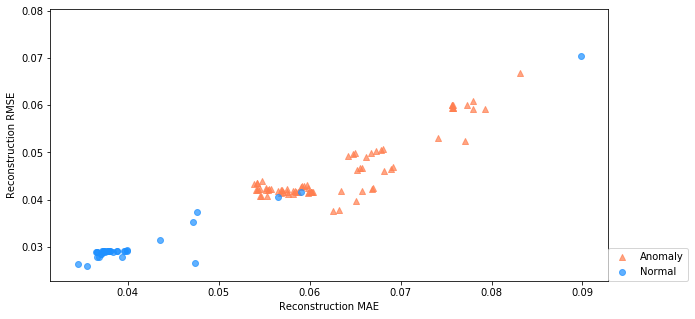

In [346]:
# Plot MSE, MAE scatter
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Normal', 'Anomaly']

plt.figure(figsize=(10, 5))
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp['MAE'], 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0])
plt.ylabel('Reconstruction RMSE'); plt.xlabel('Reconstruction MAE')
plt.show()

### LSTM

In [461]:
from sklearn.model_selection import train_test_split
df_features = pd.DataFrame(features)
X = df_features
Y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

1619862819.817318
Epoch 1/60
3/3 - 2s - loss: 0.3343 - val_loss: 0.2383
Epoch 2/60
3/3 - 0s - loss: 0.3264 - val_loss: 0.2355
Epoch 3/60
3/3 - 0s - loss: 0.3213 - val_loss: 0.2310
Epoch 4/60
3/3 - 0s - loss: 0.3171 - val_loss: 0.2294
Epoch 5/60
3/3 - 0s - loss: 0.3134 - val_loss: 0.2233
Epoch 6/60
3/3 - 0s - loss: 0.3080 - val_loss: 0.2208
Epoch 7/60
3/3 - 0s - loss: 0.3044 - val_loss: 0.2173
Epoch 8/60
3/3 - 0s - loss: 0.3001 - val_loss: 0.2154
Epoch 9/60
3/3 - 0s - loss: 0.2961 - val_loss: 0.2128
Epoch 10/60
3/3 - 0s - loss: 0.2923 - val_loss: 0.2110
Epoch 11/60
3/3 - 0s - loss: 0.2888 - val_loss: 0.2082
Epoch 12/60
3/3 - 0s - loss: 0.2846 - val_loss: 0.2054
Epoch 13/60
3/3 - 0s - loss: 0.2802 - val_loss: 0.2036
Epoch 14/60
3/3 - 0s - loss: 0.2762 - val_loss: 0.2001
Epoch 15/60
3/3 - 0s - loss: 0.2713 - val_loss: 0.1979
Epoch 16/60
3/3 - 0s - loss: 0.2667 - val_loss: 0.1955
Epoch 17/60
3/3 - 0s - loss: 0.2619 - val_loss: 0.1926
Epoch 18/60
3/3 - 0s - loss: 0.2567 - val_loss: 0.1902
E

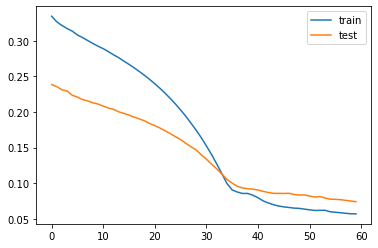

In [462]:
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
print(time.time())
history = model.fit(X_train, Y_train, epochs=60, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)
print(time.time())
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [463]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# make a prediction
yhat = model.predict(X_test)
print(yhat)
print(Y_test)

[[ 1.10833375e-02]
 [-4.25739307e-03]
 [ 8.50316323e-03]
 [ 1.34849576e-02]
 [-5.40818740e-03]
 [-2.83635315e-03]
 [ 1.00309777e+00]
 [-1.07939902e-03]
 [-7.26059172e-03]
 [ 9.85587955e-01]
 [ 9.40477371e-01]
 [ 1.87965050e-01]
 [ 1.65106013e-01]
 [ 1.25264451e-02]
 [ 9.69299436e-01]
 [ 1.38841954e-03]
 [-8.62436090e-03]
 [ 7.78834969e-02]
 [-3.70915979e-03]
 [-4.74452414e-03]
 [-1.41233660e-03]
 [-1.11578396e-02]
 [ 1.01531887e+00]
 [-2.77991984e-02]
 [ 9.99534309e-01]
 [-2.38189176e-02]
 [ 1.55120008e-02]
 [-8.61425512e-03]
 [ 1.01224363e+00]
 [-3.91851785e-03]
 [ 1.49969393e-02]
 [ 1.80335287e-02]
 [ 2.11886652e-02]
 [-5.22697251e-03]
 [ 9.88739371e-01]
 [-3.38890636e-03]
 [ 1.00215924e+00]
 [-5.27261849e-03]
 [ 1.10359956e-02]
 [-1.53765723e-01]
 [-8.93450715e-03]
 [ 1.10543976e-02]
 [ 1.01352489e+00]
 [ 7.30259437e-03]
 [-2.58919690e-02]
 [-8.33653938e-03]
 [ 9.48420763e-01]
 [-9.71294066e-05]
 [ 1.04559457e+00]
 [-1.83777756e-03]]
[0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 

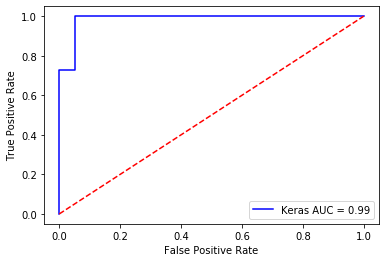

In [464]:
fpr, tpr, threshold = roc_curve(Y_test, yhat)   
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, 'b', label='Keras AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = StandardScaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
Y_test = Y_test.reshape((len(Y_test), 1))
inv_y = np.concatenate((Y_test, X_test[:, 1:]), axis=1)
inv_y = StandardScaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)